In [ ]:
# Step 1: Data Preprocessing

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




In [ ]:
# Load the dataset
df = pd.read_csv('/content/ecommerce_data.csv', encoding='ISO-8859-1')


In [ ]:
# Show the first few rows to ensure the file is read correctly
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# Check the shape of the dataset (number of rows and columns)
print(f"Dataset shape: {df.shape}")

# Check column names and data types
print("Column Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display some general statistics of the dataset
print("\nGeneral Statistics:")
print(df.describe())

# Check for duplicate rows
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Dataset shape: (541909, 8)
Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

General Statistics:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4

In [ ]:
# Findings:
# Missing Values:
# Description column has 1,454 missing values.
# CustomerID has a significant number of missing values (135,080).
# Negative Values in Quantity:
# Quantity column has negative values, which indicates returns (we'll need to address this).
# Duplicate Rows:
# There are 5,268 duplicate rows in the dataset.

In [ ]:
# Handling Duplicates

In [ ]:
# Drop duplicate rows
df = df.drop_duplicates()

# Verify if duplicates are removed
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")


Number of duplicate rows after removal: 0


In [ ]:
# # # Handling Missing Values

In [ ]:
# Drop rows where CustomerID is missing
df = df.dropna(subset=['CustomerID'])

# Verify if missing values in CustomerID are handled
print(f"Missing values in CustomerID: {df['CustomerID'].isnull().sum()}")


Missing values in CustomerID: 0


In [ ]:
# Drop rows where Description is missing
df = df.dropna(subset=['Description'])

# Verify if missing values in Description are handled
print(f"Missing values in Description: {df['Description'].isnull().sum()}")


Missing values in Description: 0


In [ ]:
# Separate the return transactions (negative quantity)
returns_df = df[df['Quantity'] < 0]

# Keep only positive transactions in the main dataframe
df = df[df['Quantity'] > 0]

# Display the shape of both DataFrames for verification
print(f"Shape of original dataset (after handling returns): {df.shape}")
print(f"Shape of returns dataset: {returns_df.shape}")


Shape of original dataset (after handling returns): (392732, 8)
Shape of returns dataset: (8872, 8)


In [ ]:
# Convert InvoiceDate to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Verify the data type of InvoiceDate
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392732 non-null  object        
 1   StockCode    392732 non-null  object        
 2   Description  392732 non-null  object        
 3   Quantity     392732 non-null  int64         
 4   InvoiceDate  392732 non-null  datetime64[ns]
 5   UnitPrice    392732 non-null  float64       
 6   CustomerID   392732 non-null  float64       
 7   Country      392732 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


In [ ]:
# Define the reference date as the last date in the dataset
reference_date = df['InvoiceDate'].max()

# Create the RFM DataFrame
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    Monetary=('UnitPrice', lambda x: (x * df.loc[x.index, 'Quantity']).sum())
).reset_index()

# Display the first few rows of the RFM DataFrame
print(rfm_df.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      325          1  77183.60
1     12347.0        1          7   4310.00
2     12348.0       74          4   1797.24
3     12349.0       18          1   1757.55
4     12350.0      309          1    334.40


In [ ]:
# We can categorize customers into segments like:

# High Value: High Frequency and Monetary, Low Recency
# Loyal Customers: High Frequency, Moderate Monetary
# At Risk: High Recency, Low Frequency, and Monetary

In [ ]:
# Define RFM segmentation
def rfm_segmentation(row):
    if row['Recency'] <= 30 and row['Frequency'] > 5 and row['Monetary'] > 500:
        return 'High Value'
    elif row['Frequency'] > 5:
        return 'Loyal Customers'
    elif row['Recency'] <= 30:
        return 'At Risk'
    else:
        return 'Other'

# Apply the segmentation function
rfm_df['Segment'] = rfm_df.apply(rfm_segmentation, axis=1)

# Display the updated RFM DataFrame with segments
print(rfm_df.head())


   CustomerID  Recency  Frequency  Monetary     Segment
0     12346.0      325          1  77183.60       Other
1     12347.0        1          7   4310.00  High Value
2     12348.0       74          4   1797.24       Other
3     12349.0       18          1   1757.55     At Risk
4     12350.0      309          1    334.40       Other


In [ ]:
# # # # High Value: Customers like ID 12347, who are recent, frequent, and have spent a significant amount. These customers are crucial for retention strategies.
# # # Loyal Customers: Although not shown in sample, this segment would include customers who frequently purchase but may not spend as much or have a lower recency.
# # At Risk: Customers like ID 12349, who haven’t purchased recently and have low frequency and monetary values. They may need targeted re-engagement strategies.
# Other: This segment includes customers with varied purchasing behavior who don’t fit neatly into the above categories.

In [ ]:
# Visualizations

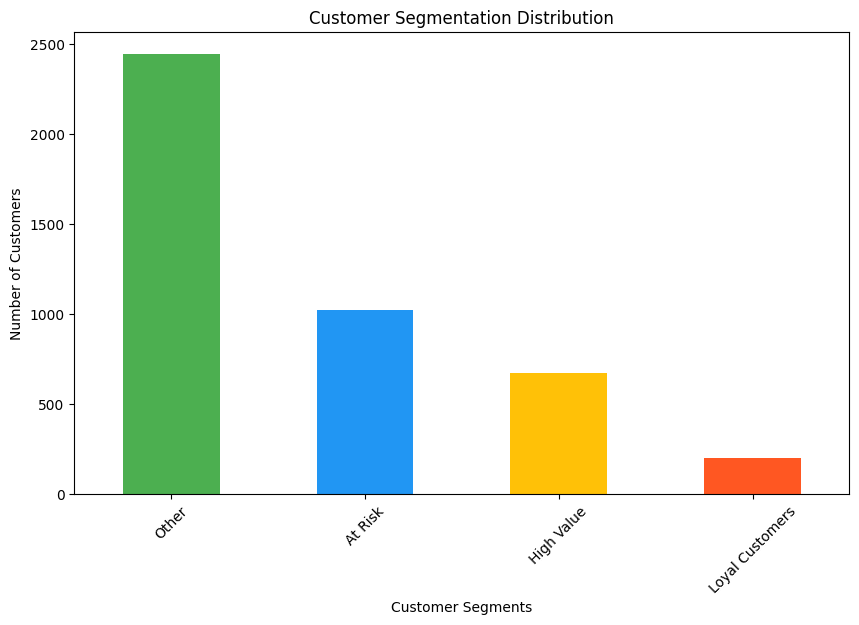

In [ ]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_counts = rfm_df['Segment'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar', color=['#4CAF50', '#2196F3', '#FFC107', '#FF5722'])
plt.title('Customer Segmentation Distribution')
plt.xlabel('Customer Segments')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate Average Order Value (AOV)
aov = rfm_df['Monetary'].mean()
print(f'Average Order Value (AOV): {aov}')


Average Order Value (AOV): 2048.2159239456096


In [ ]:
# Calculate Purchase Frequency (PF)
pf = rfm_df['Frequency'].mean()
print(f'Purchase Frequency (PF): {pf}')


Purchase Frequency (PF): 4.271952062687255


In [ ]:
# Assume average customer lifespan in years
customer_lifespan = 3  # example lifespan


In [ ]:
# Calculate Customer Lifetime Value (CLV)
clv = aov * pf * customer_lifespan
print(f'Customer Lifetime Value (CLV): {clv}')


Customer Lifetime Value (CLV): 26249.640723384986


In [ ]:
# First, calculate the Monetary value in the original DataFrame
df['Monetary'] = df['Quantity'] * df['UnitPrice']

# Then, create a new DataFrame for monthly sales
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M')).agg({'Quantity': 'sum', 'Monetary': 'sum'}).reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()


In [ ]:
print(monthly_sales.head())


  InvoiceDate  Quantity    Monetary
0  2010-12-01    311063  570422.730
1  2011-01-01    348522  568101.310
2  2011-02-01    265043  446084.920
3  2011-03-01    347623  594081.760
4  2011-04-01    291369  468374.331


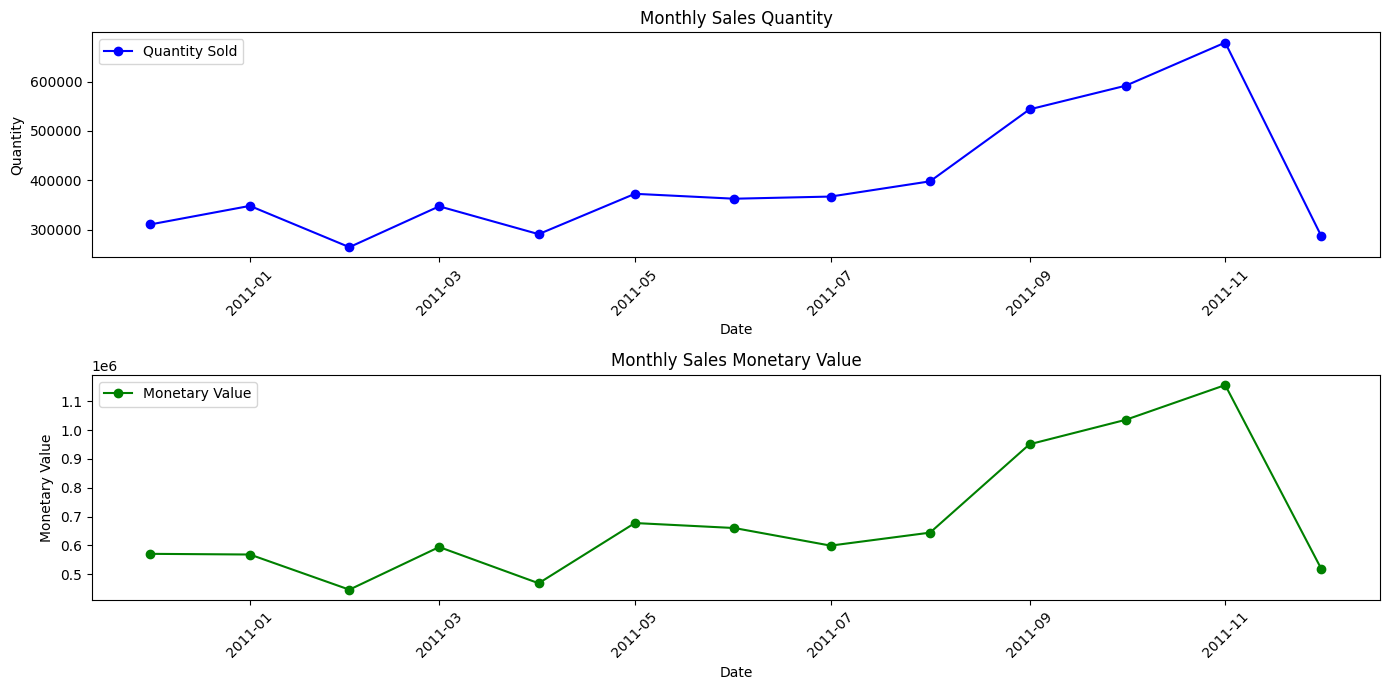

In [ ]:
import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(14, 7))

# Plot Quantity
plt.subplot(2, 1, 1)
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['Quantity'], marker='o', color='b', label='Quantity Sold')
plt.title('Monthly Sales Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.legend()

# Plot Monetary Value
plt.subplot(2, 1, 2)
plt.plot(monthly_sales['InvoiceDate'], monthly_sales['Monetary'], marker='o', color='g', label='Monetary Value')
plt.title('Monthly Sales Monetary Value')
plt.xlabel('Date')
plt.ylabel('Monetary Value')
plt.xticks(rotation=45)
plt.legend()

# Show plots
plt.tight_layout()
plt.show()


In [ ]:
# Group by StockCode and Description to get total sales and quantity
product_performance = df.groupby(['StockCode', 'Description']).agg({'Quantity': 'sum', 'Monetary': 'sum'}).reset_index()

# Sort by Monetary value to get the top products
top_products = product_performance.sort_values(by='Monetary', ascending=False).head(10)


In [ ]:
print(top_products)


     StockCode                         Description  Quantity   Monetary
2602     23843         PAPER CRAFT , LITTLE BIRDIE     80995  168469.60
1318     22423            REGENCY CAKESTAND 3 TIER     12384  142264.75
3459    85123A  WHITE HANGING HEART T-LIGHT HOLDER     36706  100392.10
3444    85099B             JUMBO BAG RED RETROSPOT     46078   85040.54
2100     23166      MEDIUM CERAMIC TOP STORAGE JAR     77916   81416.73
3896      POST                             POSTAGE      3120   77803.96
2799     47566                       PARTY BUNTING     15283   68785.23
3278     84879       ASSORTED COLOUR BIRD ORNAMENT     35263   56413.03
3894         M                              Manual      6939   53419.93
2006     23084                  RABBIT NIGHT LIGHT     27153   51251.24


In [ ]:
# Insights from Product Performance:
# Top Product: The product "PAPER CRAFT, LITTLE BIRDIE" has the highest sales, both in quantity and monetary value, indicating strong demand.
# Diverse Categories: The list includes a mix of decorative items and storage solutions, suggesting a variety of customer preferences.
# Opportunity for Promotion: The top products can be targeted for future promotions, especially around peak shopping seasons.

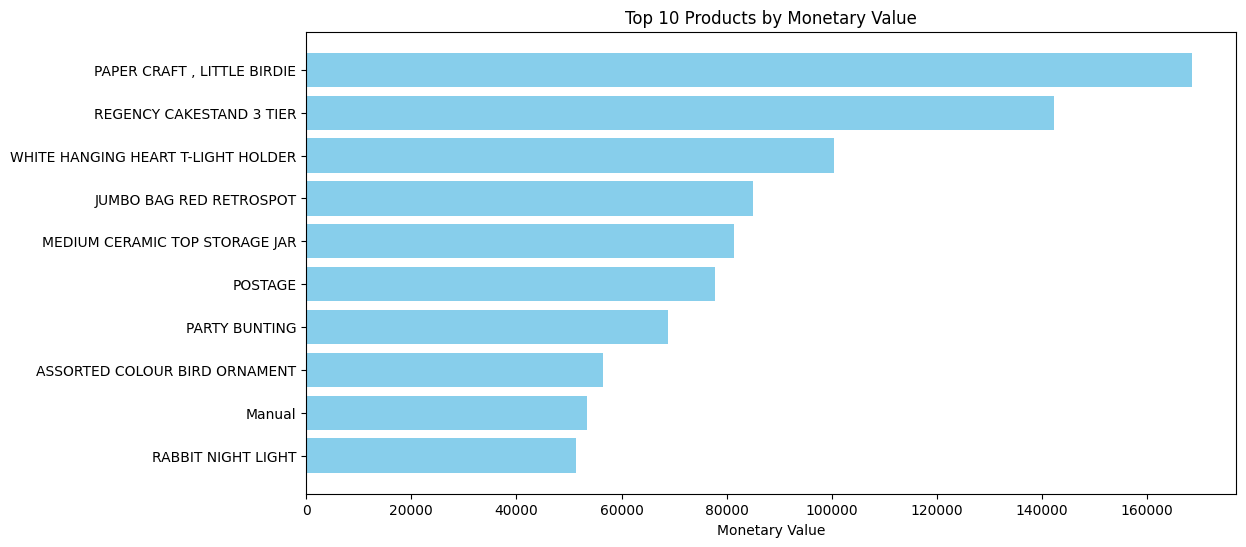

In [ ]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Plotting the bar chart for top products
plt.barh(top_products['Description'], top_products['Monetary'], color='skyblue')
plt.xlabel('Monetary Value')
plt.title('Top 10 Products by Monetary Value')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [ ]:
# Extract day of the week and hour from InvoiceDate
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour


In [ ]:
print(df[['InvoiceDate', 'DayOfWeek', 'Hour']].head())
# Extract Day of the Week and Hour from Invoice Date

          InvoiceDate  DayOfWeek  Hour
0 2010-12-01 08:26:00  Wednesday     8
1 2010-12-01 08:26:00  Wednesday     8
2 2010-12-01 08:26:00  Wednesday     8
3 2010-12-01 08:26:00  Wednesday     8
4 2010-12-01 08:26:00  Wednesday     8


In [ ]:
# Analyze Sales by Day of the Week

In [ ]:
# Group by DayOfWeek to get total sales and quantity
sales_by_day = df.groupby('DayOfWeek').agg({'Quantity': 'sum', 'Monetary': 'sum'}).reset_index()

# Sort the days for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day['DayOfWeek'] = pd.Categorical(sales_by_day['DayOfWeek'], categories=days_order, ordered=True)
sales_by_day = sales_by_day.sort_values('DayOfWeek')

# Display the results
print(sales_by_day)


   DayOfWeek  Quantity     Monetary
1     Monday    766919  1363604.401
4    Tuesday   1005772  1697733.801
5  Wednesday    960128  1584283.830
3   Thursday   1150224  1973015.730
0     Friday    821859  1483080.811
2     Sunday    460984   785490.321


In [ ]:
# Peak Day: Thursday has the highest sales both in quantity and monetary value, suggesting it might be a key day for customer purchases.
# Trends: Sales are significantly higher on weekdays compared to weekends, with Sunday being the lowest.

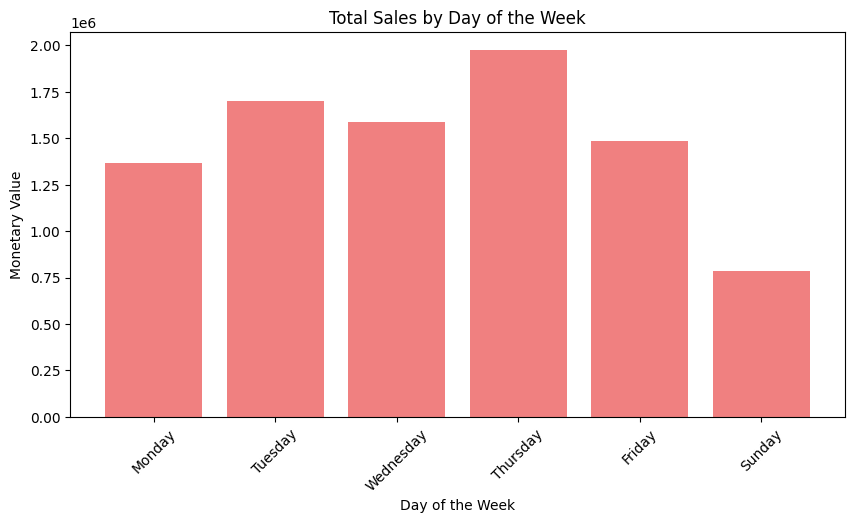

In [ ]:
# Set the plot size
plt.figure(figsize=(10, 5))

# Plotting the bar chart for sales by day of the week
plt.bar(sales_by_day['DayOfWeek'], sales_by_day['Monetary'], color='lightcoral')
plt.xlabel('Day of the Week')
plt.ylabel('Monetary Value')
plt.title('Total Sales by Day of the Week')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Group by Hour to get total sales and quantity
sales_by_hour = df.groupby('Hour').agg({'Quantity': 'sum', 'Monetary': 'sum'}).reset_index()

# Display the results
print(sales_by_hour)


    Hour  Quantity     Monetary
0      6         1        4.250
1      7     15370    31059.210
2      8    157817   281997.790
3      9    482217   842392.341
4     10    774836  1259267.591
5     11    645582  1101177.600
6     12    822376  1373695.390
7     13    680306  1168724.200
8     14    556564   991992.821
9     15    551549   963559.680
10    16    253208   467380.560
11    17    129147   233811.591
12    18     54900   104744.990
13    19     32505    48568.400
14    20      9508    18832.480


In [ ]:
# Peak Hour: The highest sales occur between 12 PM and 2 PM, indicating that this is likely the most popular shopping time.
# Decline in Sales: After 3 PM, there's a noticeable decline in both quantity and monetary value, suggesting that customer activity drops significantly in the evening.

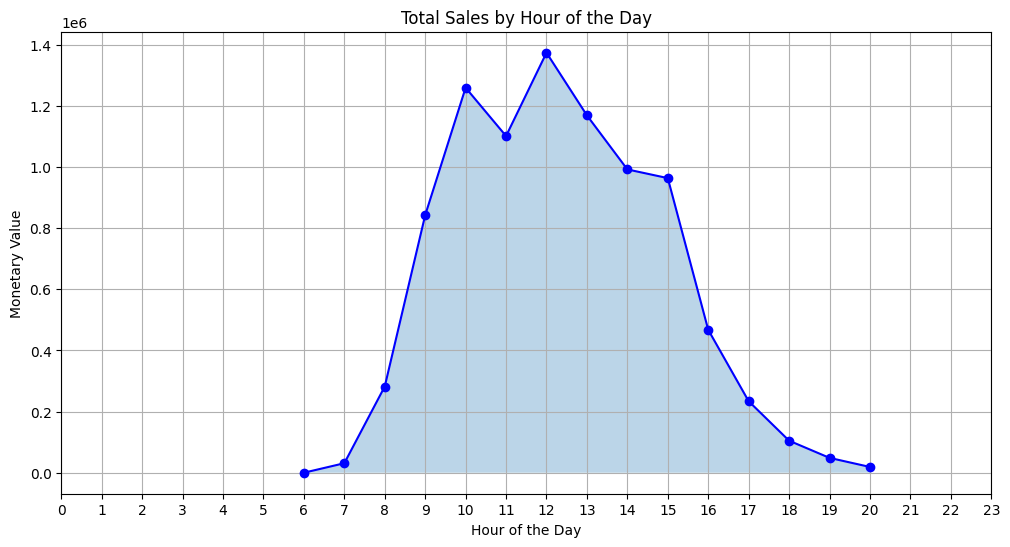

In [ ]:
# Set the plot size
plt.figure(figsize=(12, 6))

# Plotting the line chart for sales by hour
plt.plot(sales_by_hour['Hour'], sales_by_hour['Monetary'], marker='o', color='blue')
plt.fill_between(sales_by_hour['Hour'], sales_by_hour['Monetary'], alpha=0.3)
plt.xticks(range(0, 24))
plt.xlabel('Hour of the Day')
plt.ylabel('Monetary Value')
plt.title('Total Sales by Hour of the Day')
plt.grid()
plt.show()


In [ ]:
# The exponential growth in sales until 10 AM suggests strong morning engagement, with a peak around noon, which is likely influenced by lunch breaks or midday shopping.

In [ ]:
# Average Days Between Purchases

In [ ]:
# Calculate the difference in days between purchases for each customer
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
avg_days_between = df.groupby('CustomerID')['InvoiceDate'].diff().dt.days

# Get the average days between purchases
avg_days_between_summary = avg_days_between.groupby(df['CustomerID']).mean().reset_index()
avg_days_between_summary.columns = ['CustomerID', 'AvgDaysBetweenPurchases']

# Display the summary
print(avg_days_between_summary)


      CustomerID  AvgDaysBetweenPurchases
0        12346.0                      NaN
1        12347.0                 2.000000
2        12348.0                 9.400000
3        12349.0                 0.000000
4        12350.0                 0.000000
...          ...                      ...
4334     18280.0                 0.000000
4335     18281.0                 0.000000
4336     18282.0                10.727273
4337     18283.0                 0.454167
4338     18287.0                 2.275362

[4339 rows x 2 columns]


In [ ]:
# Classify Customers Based on Purchase Frequency

In [ ]:
# Define customer segments based on average days between purchases
def categorize_customers(avg_days):
    if avg_days <= 3:
        return 'Frequent Buyer'
    elif avg_days <= 10:
        return 'Occasional Buyer'
    else:
        return 'Infrequent Buyer'

# Merge the average days data with the original data to classify customers
avg_days_between_summary['Segment'] = avg_days_between_summary['AvgDaysBetweenPurchases'].apply(categorize_customers)

# Display the categorized customer segments
segment_summary = avg_days_between_summary['Segment'].value_counts().reset_index()
segment_summary.columns = ['Segment', 'Count']

print(segment_summary)


            Segment  Count
0    Frequent Buyer   3209
1  Occasional Buyer    805
2  Infrequent Buyer    325


In [ ]:
# Count customers in each segment
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

# Display the segment counts
print(segment_counts)


           Segment  Count
0            Other   2446
1          At Risk   1021
2       High Value    671
3  Loyal Customers    201


<ipython-input-48-d9e856b8f664>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='Segment', y='Count', palette='viridis')


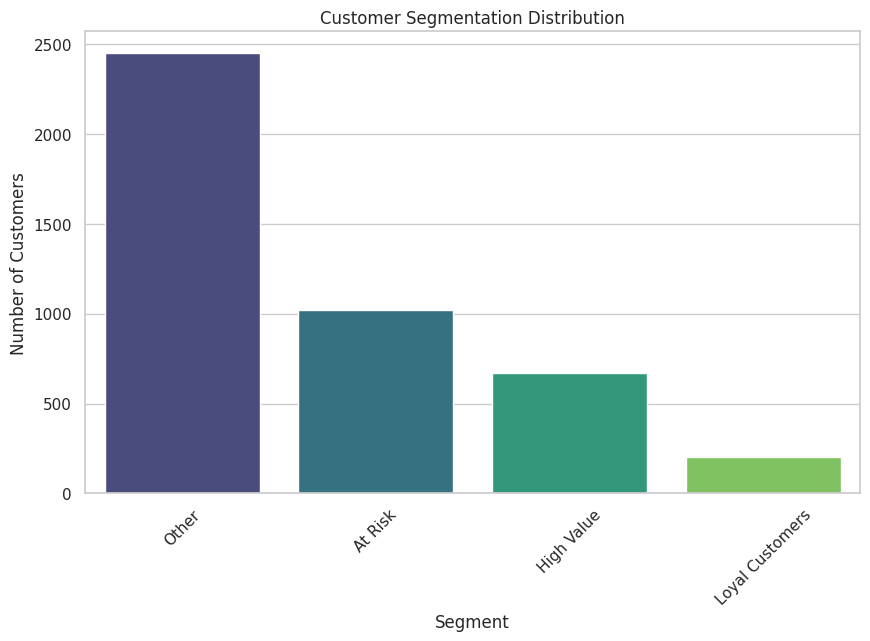

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='Segment', y='Count', palette='viridis')
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate average monetary value by segment
avg_monetary_by_segment = rfm_df.groupby('Segment')['Monetary'].mean().reset_index()
avg_monetary_by_segment.columns = ['Segment', 'Average Monetary Value']

# Display the results
print(avg_monetary_by_segment)


           Segment  Average Monetary Value
0          At Risk             1143.261254
1       High Value             7687.361967
2  Loyal Customers             3660.567811
3            Other              746.502512


In [ ]:
# High Value customers are significantly contributing to revenue.
# Loyal Customers also show a decent monetary value, which is promising for retention efforts.
# At Risk and Other segments have lower monetary values, indicating potential areas for improvement.

In [ ]:
# Calculate average metrics for each segment
segment_analysis = rfm_df.groupby('Segment').agg({
    'Monetary': 'mean',
    'Frequency': 'mean',
    'Recency': 'mean'
}).reset_index()

# Display the results
print(segment_analysis)


           Segment     Monetary   Frequency     Recency
0          At Risk  3455.165357    3.107143   15.839286
1       High Value  4698.657145  197.727918   12.651420
2  Loyal Customers   917.881398   50.926741  121.068567
3            Other   788.414016    2.954918  200.930328


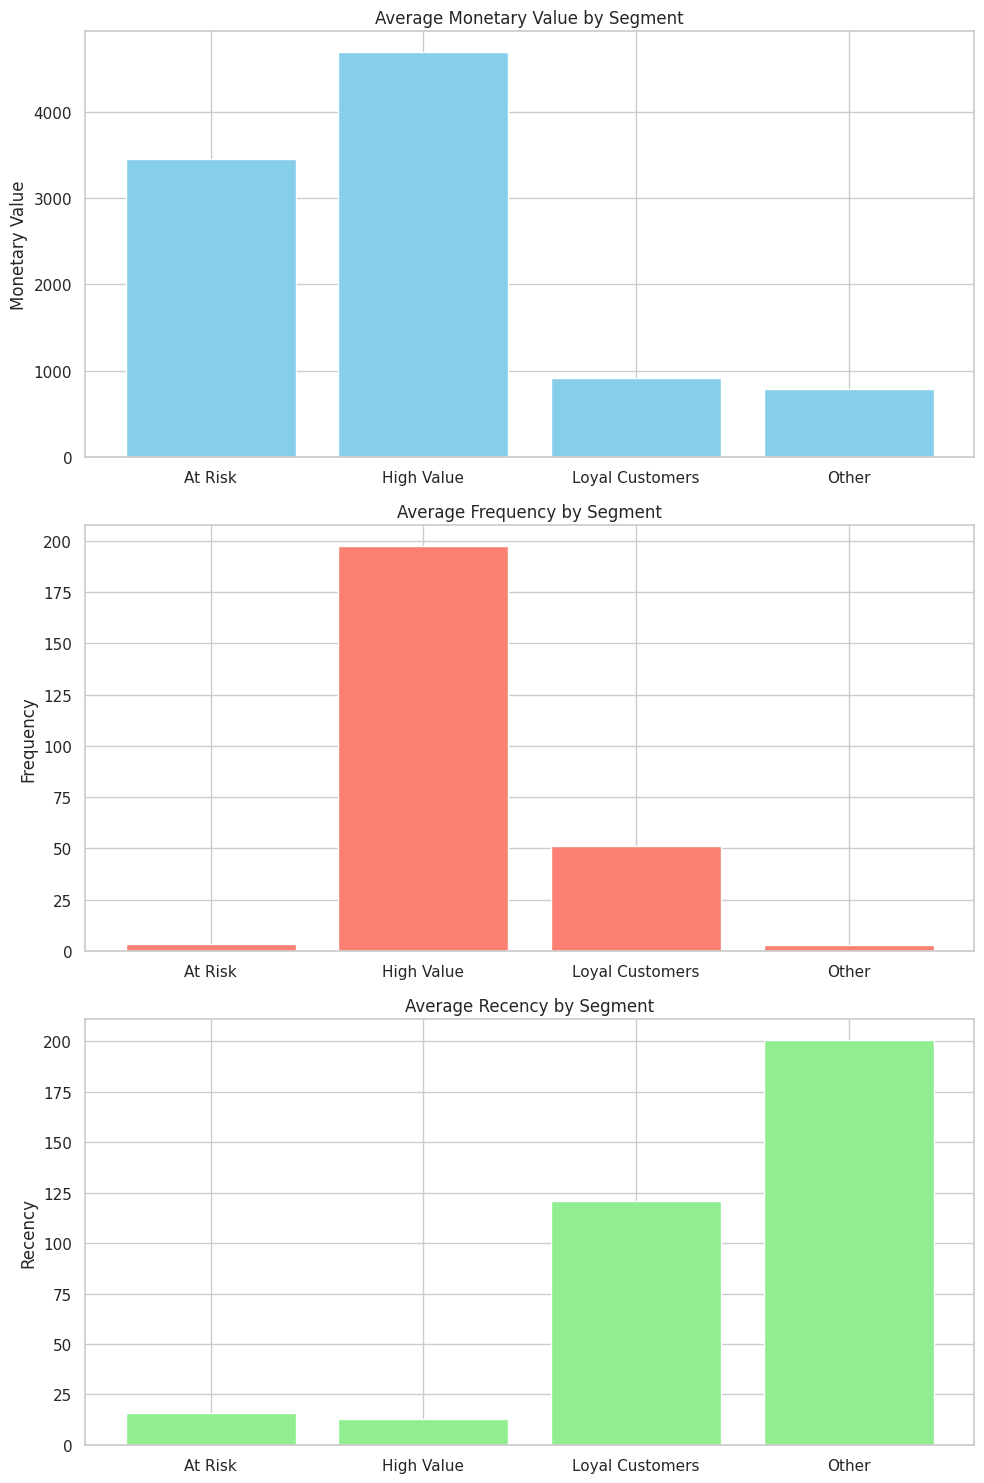

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Monetary
axs[0].bar(segment_analysis['Segment'], segment_analysis['Monetary'], color='skyblue')
axs[0].set_title('Average Monetary Value by Segment')
axs[0].set_ylabel('Monetary Value')

# Plot for Frequency
axs[1].bar(segment_analysis['Segment'], segment_analysis['Frequency'], color='salmon')
axs[1].set_title('Average Frequency by Segment')
axs[1].set_ylabel('Frequency')

# Plot for Recency
axs[2].bar(segment_analysis['Segment'], segment_analysis['Recency'], color='lightgreen')
axs[2].set_title('Average Recency by Segment')
axs[2].set_ylabel('Recency')

plt.tight_layout()
plt.show()


In [ ]:
# 63% Loyal Customers: A solid base, indicating strong retention.
# 29% High Value: Significant potential for upselling or targeted marketing.
# 5.6% Other: These may need engagement strategies to improve retention.
# 1.3% At Risk: Critical to focus on this group to prevent churn.

           Segment  Total_Monetary  Average_Monetary
0          At Risk      193489.260       3455.165357
1       High Value     5957897.260       4698.657145
2  Loyal Customers     2543449.354        917.881398
3            Other      192373.020        788.414016


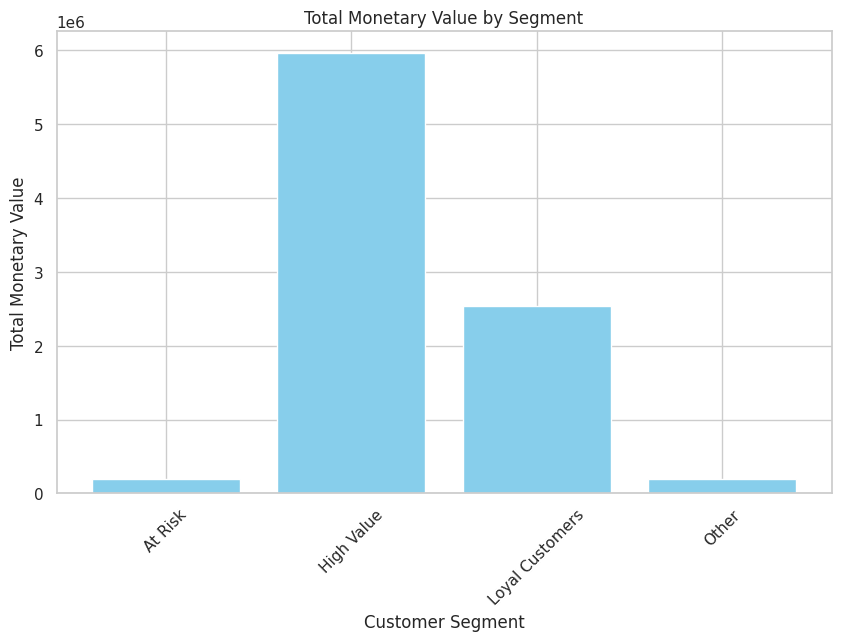

In [ ]:
# Calculate total and average monetary value per segment
monetary_summary = rfm_df.groupby('Segment').agg(
    Total_Monetary=('Monetary', 'sum'),
    Average_Monetary=('Monetary', 'mean')
).reset_index()

# Display the summary
print(monetary_summary)

# Optional: Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(monetary_summary['Segment'], monetary_summary['Total_Monetary'], color='skyblue')
plt.title('Total Monetary Value by Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Monetary Value')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Calculate purchase frequency by segment
purchase_frequency_segment = rfm_df.groupby('Segment')['Frequency'].mean().reset_index()

# Rename columns for clarity
purchase_frequency_segment.columns = ['Segment', 'Average Frequency']

# Display the results
print(purchase_frequency_segment)


           Segment  Average Frequency
0          At Risk           3.107143
1       High Value         197.727918
2  Loyal Customers          50.926741
3            Other           2.954918


In [ ]:
# High Value customers have the highest average purchase frequency, indicating they shop very often.
# Loyal Customers also purchase relatively frequently, but not as much as the High Value segment.
# At Risk and Other segments have much lower average frequencies, which suggests they might need targeted engagement strategies to encourage more purchases.

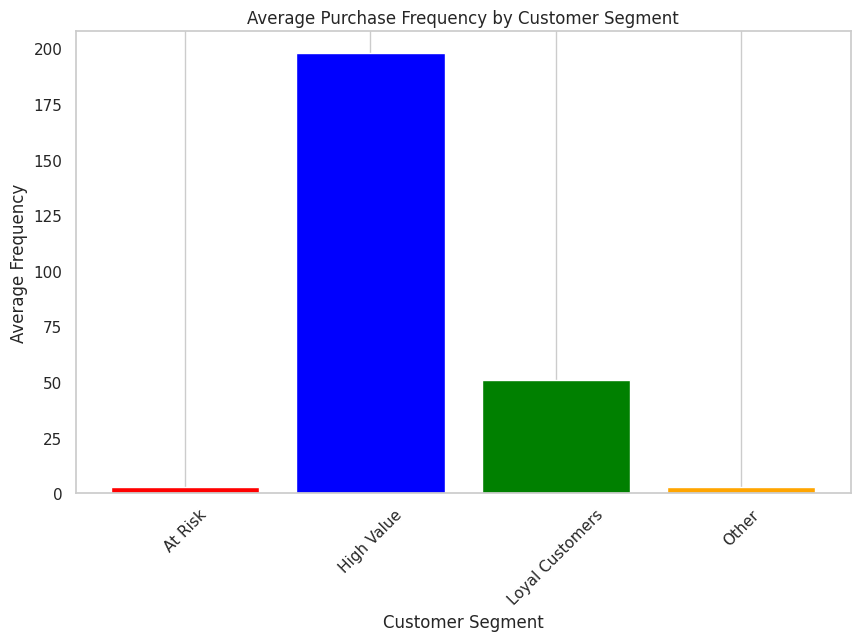

In [ ]:
import matplotlib.pyplot as plt

# Create a bar chart for average frequency by segment
plt.figure(figsize=(10, 6))
plt.bar(purchase_frequency_segment['Segment'], purchase_frequency_segment['Average Frequency'], color=['red', 'blue', 'green', 'orange'])
plt.title('Average Purchase Frequency by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


In [ ]:
# High Value customers are the most engaged, buying frequently.
# Loyal Customers still contribute significantly but at a lower frequency.
# At Risk and Other segments show much less engagement, which highlights a potential area for improvement.

In [ ]:
# Create a new DataFrame to count active customers each month
monthly_active_customers = df.groupby(df['InvoiceDate'].dt.to_period('M'))['CustomerID'].nunique()

# Calculate retention rates
retention_rates = monthly_active_customers.shift(-1) / monthly_active_customers

# Create a DataFrame to visualize retention rates
retention_df = pd.DataFrame({'Month': monthly_active_customers.index,
                             'Active_Customers': monthly_active_customers.values,
                             'Retention_Rate': retention_rates.values})

# Display the retention DataFrame
print(retention_df)


      Month  Active_Customers  Retention_Rate
0   2010-12               885        0.837288
1   2011-01               741        1.022942
2   2011-02               758        1.284960
3   2011-03               974        0.878850
4   2011-04               856        1.233645
5   2011-05              1056        0.938447
6   2011-06               991        0.957619
7   2011-07               949        0.985248
8   2011-08               935        1.354011
9   2011-09              1266        1.077409
10  2011-10              1364        1.220674
11  2011-11              1665        0.369369
12  2011-12               615             NaN


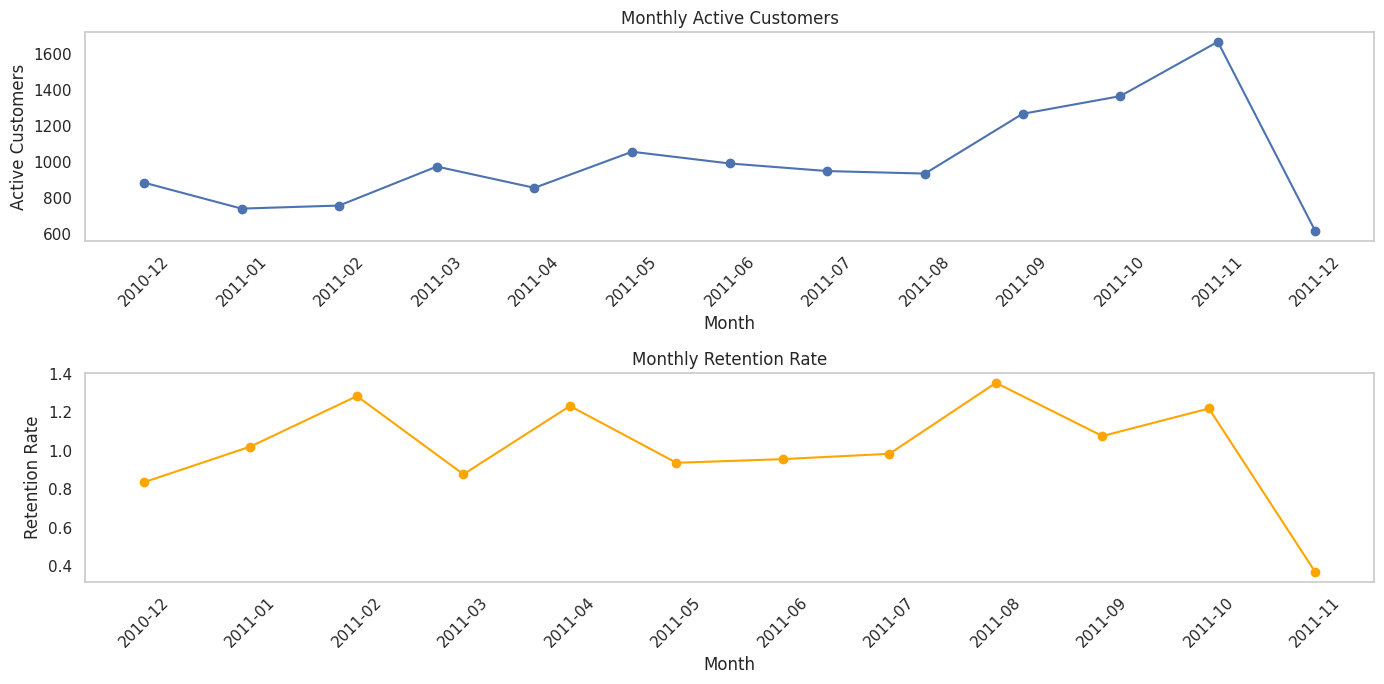

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plotting Active Customers
plt.subplot(2, 1, 1)
plt.plot(retention_df['Month'].astype(str), retention_df['Active_Customers'], marker='o')
plt.title('Monthly Active Customers')
plt.xlabel('Month')
plt.ylabel('Active Customers')
plt.xticks(rotation=45)
plt.grid()

# Plotting Retention Rate
plt.subplot(2, 1, 2)
plt.plot(retention_df['Month'].astype(str), retention_df['Retention_Rate'], marker='o', color='orange')
plt.title('Monthly Retention Rate')
plt.xlabel('Month')
plt.ylabel('Retention Rate')
plt.xticks(rotation=45)
plt.grid()

plt.tight_layout()
plt.show()


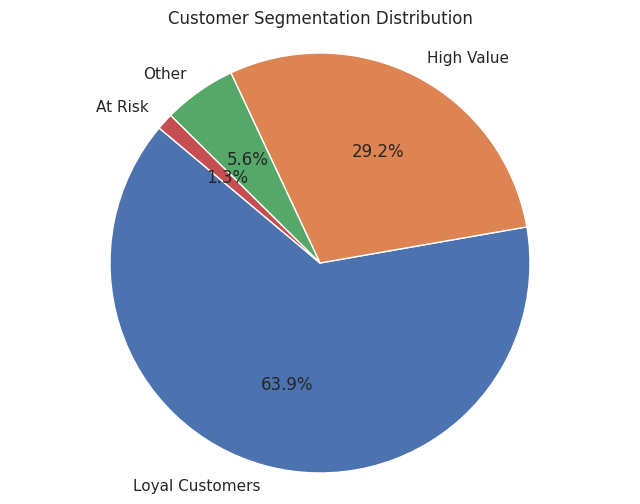

In [ ]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_counts = rfm_df['Segment'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segmentation Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [ ]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create Customer DataFrame
customer_data = df.groupby('CustomerID').agg({
    'InvoiceDate': ['max', 'min'],
    'Quantity': 'sum',
    'UnitPrice': 'sum'
}).reset_index()

# Calculate Recency, Frequency, and Monetary values
customer_data.columns = ['CustomerID', 'LastPurchase', 'FirstPurchase', 'Total_Quantity', 'Total_Monetary']
customer_data['Recency'] = (df['InvoiceDate'].max() - customer_data['LastPurchase']).dt.days
customer_data['Frequency'] = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Display the new customer data
print(customer_data.head())


   CustomerID        LastPurchase       FirstPurchase  Total_Quantity  \
0     12346.0 2011-01-18 10:01:00 2011-01-18 10:01:00           74215   
1     12347.0 2011-12-07 15:52:00 2010-12-07 14:57:00            2458   
2     12348.0 2011-09-25 13:13:00 2010-12-16 19:09:00            2341   
3     12349.0 2011-11-21 09:51:00 2011-11-21 09:51:00             631   
4     12350.0 2011-02-02 16:01:00 2011-02-02 16:01:00             197   

   Total_Monetary  Recency  Frequency  
0            1.04      325        NaN  
1          481.21        1        NaN  
2          178.71       74        NaN  
3          605.10       18        NaN  
4           65.30      309        NaN  


In [ ]:
# Define RFM segmentation
def rfm_segmentation(row):
    if row['Recency'] <= 30 and row['Frequency'] > 5 and row['Total_Monetary'] > 500:
        return 'High Value'
    elif row['Frequency'] > 5:
        return 'Loyal Customers'
    elif row['Recency'] <= 30:
        return 'At Risk'
    else:
        return 'Other'

# Apply the segmentation function
customer_data['Segment'] = customer_data.apply(rfm_segmentation, axis=1)

# Display the updated DataFrame with segments
print(customer_data.head())


   CustomerID        LastPurchase       FirstPurchase  Total_Quantity  \
0     12346.0 2011-01-18 10:01:00 2011-01-18 10:01:00           74215   
1     12347.0 2011-12-07 15:52:00 2010-12-07 14:57:00            2458   
2     12348.0 2011-09-25 13:13:00 2010-12-16 19:09:00            2341   
3     12349.0 2011-11-21 09:51:00 2011-11-21 09:51:00             631   
4     12350.0 2011-02-02 16:01:00 2011-02-02 16:01:00             197   

   Total_Monetary  Recency  Frequency  Segment  
0            1.04      325        NaN    Other  
1          481.21        1        NaN  At Risk  
2          178.71       74        NaN    Other  
3          605.10       18        NaN  At Risk  
4           65.30      309        NaN    Other  


In [ ]:
# Add country data to customer_data
customer_data['Country'] = df.groupby('CustomerID')['Country'].first().values

# Grouping by country and aggregating metrics
country_data = customer_data.groupby('Country').agg({
    'Total_Monetary': 'sum',
    'Frequency': 'mean',
    'Recency': 'mean',
    'CustomerID': 'nunique'  # Count unique customers
}).reset_index()

# Rename columns for clarity
country_data.columns = ['Country', 'Total_Monetary', 'Average_Frequency', 'Average_Recency', 'Active_Customers']

# Calculate Retention Rate (assumed)
country_data['Retention_Rate'] = country_data['Active_Customers'] / country_data['Active_Customers'].sum()

# Display the country-level data
print(country_data)


                 Country  Total_Monetary  Average_Frequency  Average_Recency  \
0              Australia        3865.700                NaN        99.222222   
1                Austria        1514.870                NaN       144.555556   
2                Bahrain          78.950                NaN       208.000000   
3                Belgium        7288.670                NaN        95.000000   
4                 Brazil         142.600                NaN       238.000000   
5                 Canada         910.580                NaN       185.250000   
6        Channel Islands        3388.000                NaN       139.666667   
7                 Cyprus        3696.190                NaN       122.428571   
8         Czech Republic          78.270                NaN        63.000000   
9                Denmark        1282.190                NaN        45.375000   
10                  EIRE       32134.960                NaN        56.666667   
11    European Community         289.800

In [ ]:
# Fill NaN values in Average_Frequency with 0 (or another suitable value)
country_data['Average_Frequency'] = country_data['Average_Frequency'].fillna(0)


<ipython-input-72-5c993f7cd7b4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Monetary', y='Country', data=country_data_sorted, palette='viridis')


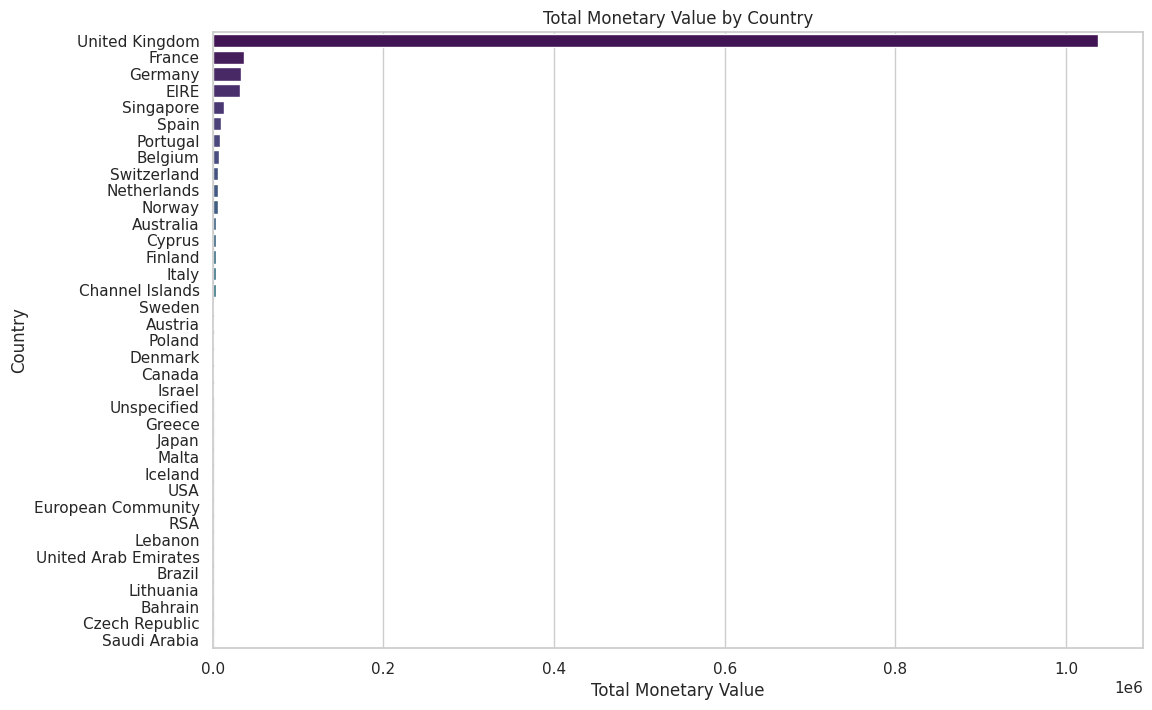

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style
sns.set(style="whitegrid")

# Sort by Total Monetary Value
country_data_sorted = country_data.sort_values(by='Total_Monetary', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Total_Monetary', y='Country', data=country_data_sorted, palette='viridis')
plt.title('Total Monetary Value by Country')
plt.xlabel('Total Monetary Value')
plt.ylabel('Country')
plt.show()


<ipython-input-75-2499e7d2a5a7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Retention_Rate', y='Country', data=country_data_sorted, palette='magma')


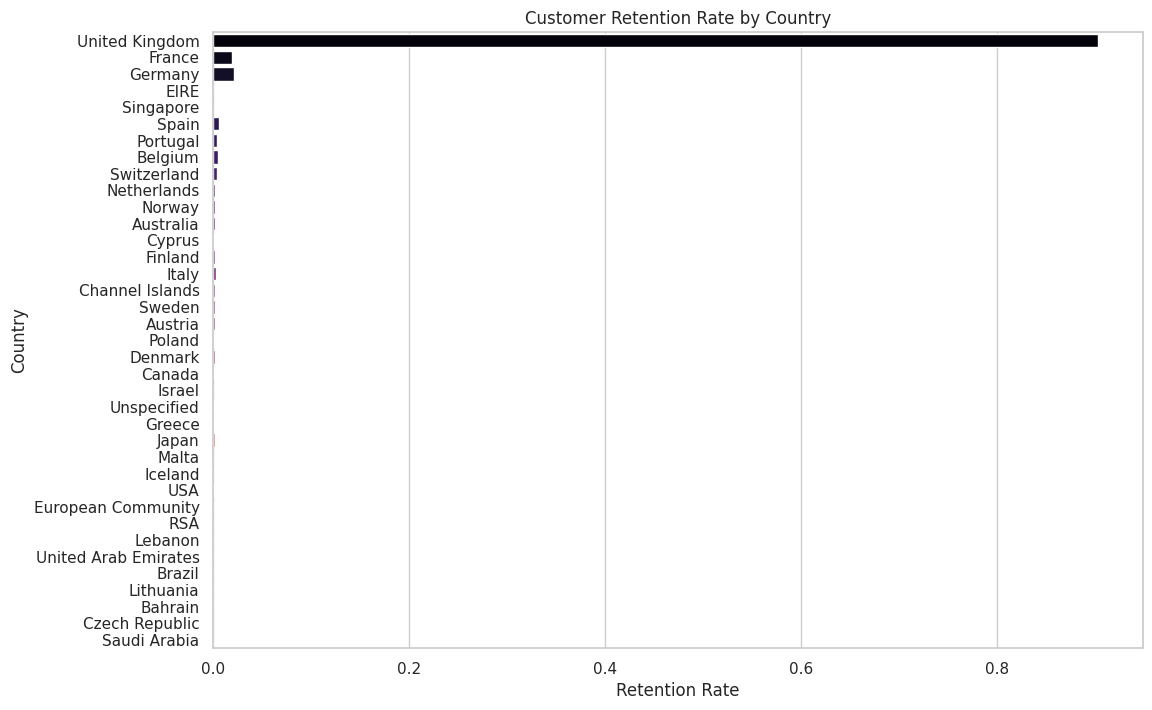

In [ ]:
# Plotting Retention Rate
plt.figure(figsize=(12, 8))
sns.barplot(x='Retention_Rate', y='Country', data=country_data_sorted, palette='magma')
plt.title('Customer Retention Rate by Country')
plt.xlabel('Retention Rate')
plt.ylabel('Country')
plt.show()


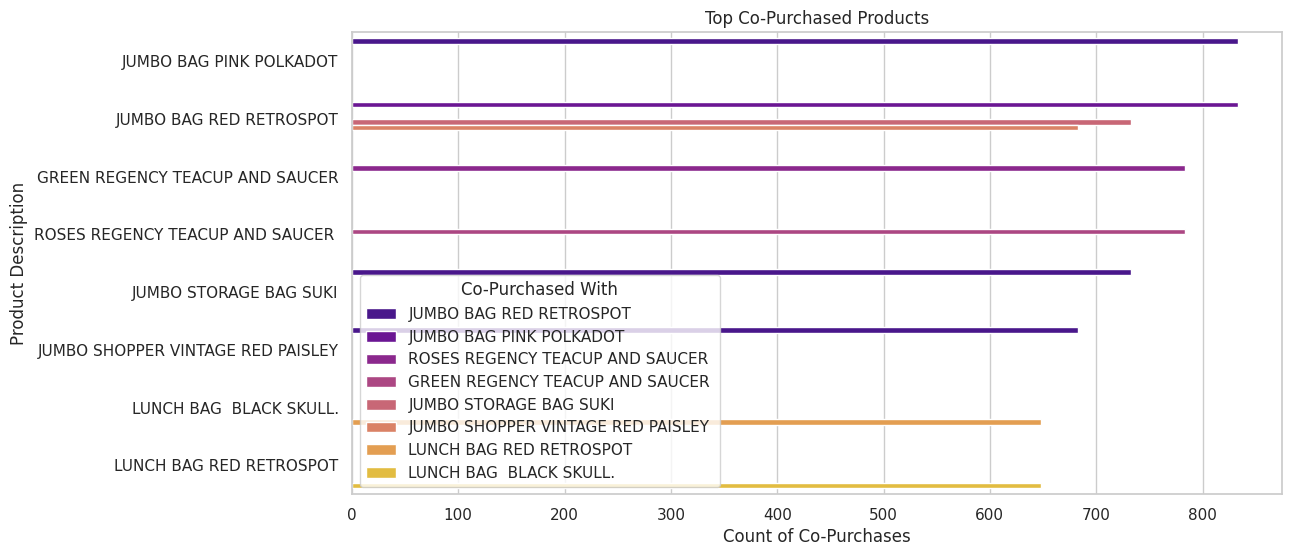

In [ ]:
# Find co-purchased products
co_purchase = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().reset_index()
co_purchase_pairs = co_purchase.merge(co_purchase, on='InvoiceNo')

# Filter out same products
co_purchase_pairs = co_purchase_pairs[co_purchase_pairs['Description_x'] != co_purchase_pairs['Description_y']]

# Count co-purchases
co_purchase_counts = co_purchase_pairs.groupby(['Description_x', 'Description_y']).size().reset_index(name='Count')

# Sort to find top co-purchased products
top_co_purchase = co_purchase_counts.sort_values(by='Count', ascending=False).head(10)

# Visualize co-purchases
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Description_x', hue='Description_y', data=top_co_purchase, palette='plasma')
plt.title('Top Co-Purchased Products')
plt.xlabel('Count of Co-Purchases')
plt.ylabel('Product Description')
plt.legend(title='Co-Purchased With')
plt.show()


In [ ]:
# Display the columns in the DataFrame
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [ ]:
df['Monetary'] = df['Quantity'] * df['UnitPrice']


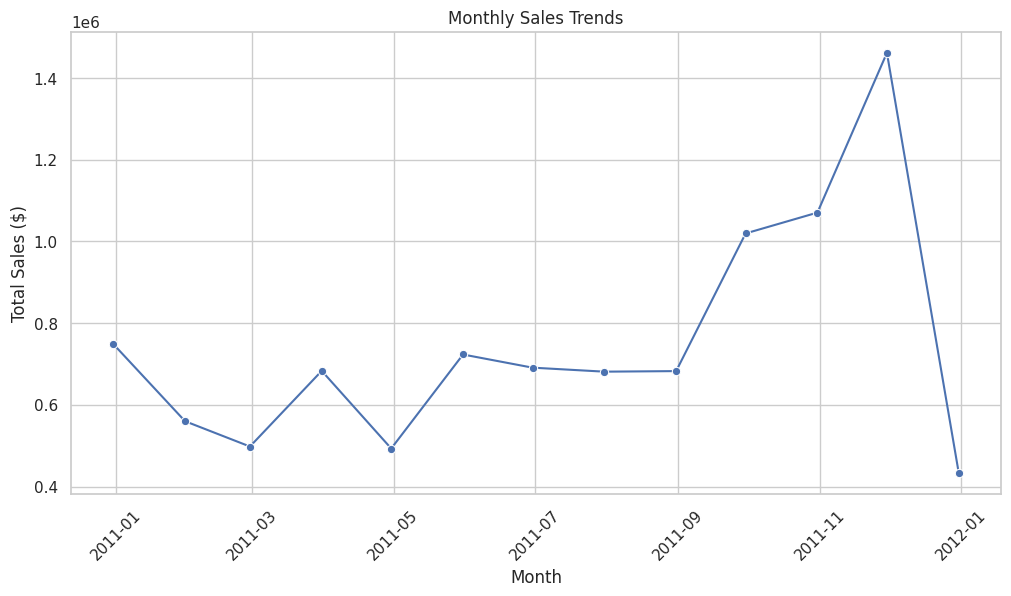

In [ ]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregate sales by month
monthly_sales = df.resample('M', on='InvoiceDate').agg({'Quantity': 'sum', 'Monetary': 'sum'}).reset_index()

# Plotting monthly sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceDate', y='Monetary', data=monthly_sales, marker='o')
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.show()
